# Flow of the hands-on session:
## 1. Pre-training
## 2. Fine-tuning
## 3. Meta-learning

## Source data - MNIST data corresponding to the classes - [0,1,2,3,4,5,6,7]
## Target data - MNIST data corresponding to the classes - [8,9]

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras import backend as k
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random


2023-01-04 08:59:15.767185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 08:59:15.767210: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Model

In [2]:
class mnist_model(keras.Model):
    def __init__(self,numclasses):
        super().__init__()
        self.conv1 = Conv2D(filters=32,kernel_size=(3,3),input_shape=(28,28,1),padding='same')
        # self.dense1 = Dense(100,activation='relu')
        self.conv2 = Conv2D(filters=64,kernel_size=(3,3),padding='same')
        self.conv3 = Conv2D(filters=128,kernel_size=(3,3),padding='same')
        self.conv4 = Conv2D(filters=192,kernel_size=(3,3),padding='same')
        self.conv5 = Conv2D(filters=256,kernel_size=(5,5),padding='same')
        self.linear = Dense(numclasses,activation='softmax')

    def call(self,x):
        x = self.conv1(x)
        x = BatchNormalization()(x)
        x = keras.activations.relu(x)
        x = MaxPooling2D((2,2))(x)      

                
        x = self.conv2(x)
        x = BatchNormalization()(x)
        x = keras.activations.relu(x)
        x = MaxPooling2D((2,2))(x)

                
        x = self.conv3(x)
        x = BatchNormalization()(x)
        x = keras.activations.relu(x)
        x = MaxPooling2D((2,2))(x)

       
        x = self.conv4(x)
        x = BatchNormalization()(x)
        x = keras.activations.relu(x)
               
        x = self.conv5(x)
        x = BatchNormalization()(x)
        x = keras.activations.relu(x)
        x = MaxPooling2D((2,2))(x)   
        
        x = Flatten()(x)     

        x = self.linear(x)
        return x

    def build_graph(self,raw_shape):
        x = tf.keras.layers.Input(shape=raw_shape)
        return Model(inputs=[x], outputs = self.call(x))
    
model = mnist_model(10)
model.build_graph([28,28,1]).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496 

2023-01-04 08:59:17.780285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 08:59:17.780926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 08:59:17.781054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-04 08:59:17.781171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-04 08:59:17.781283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

## Functions

In [3]:

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

def compute_loss(model, x, y):
    logits = model.call(x)
    loss = loss_fn(y, logits)
    return loss, logits

def compute_gradients(model, x, y):
    with tf.GradientTape() as tape:
        loss, logits = compute_loss(model, x, y)
    return tape.gradient(loss, model.trainable_variables), loss,logits

def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

def copy_model(model, x, N):
    copied_model = mnist_model(N)
    copied_model.call(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model

def get_updated_model(N,model):
    new_model = mnist_model(N)
    new_model.build_graph([28,28,1])
       
    for i in range(len(new_model.layers)-1):
        new_model.layers[i].set_weights(model.layers[i].get_weights()) 
    return new_model

## Dataset preparation

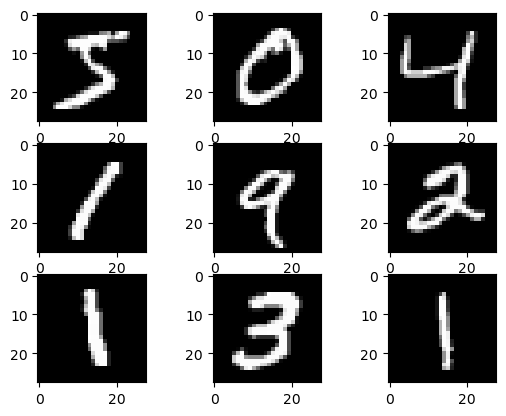

In [4]:
## Load the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# plot first few images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

x_train = x_train/255.0
x_test = x_test/255.0

In [5]:
## Classwise segregation of data
n_category = 10
pretrain_category = [0,1,2,3]
source_category = [4,5,6,7]
target_category = [8,9]

classwise_x = [[] for i in range(n_category)]
classwise_y = [[] for i in range(n_category)]

for i in range(len(x_train)):
    category = y_train[i]
    if len(classwise_x[category])<500:
        classwise_x[category].append(x_train[i])
        classwise_y[category].append(y_train[i])=
    else:
        continue

In [6]:
## Shuffle the entire data with 500 samples each
X = np.array(classwise_x).reshape(-1,28,28)
Y = np.array(classwise_y).reshape(-1)
print(X.shape,Y.shape)
X,Y = shuffle(X, Y, random_state=0)
print(Y)

(5000, 28, 28) (5000,)
[0 7 9 ... 3 5 5]


In [7]:
## Get the pre-train data
pretrain_x = []
pretrain_y = []

for i in range(len(X)):
    category = Y[i]
    if category in pretrain_category + source_category:
        pretrain_x.append(X[i])
        pretrain_y.append(category)

pretrain_x = np.array(pretrain_x)
pretrain_y = np.array(pretrain_y)

pretrain_dataset = tf.data.Dataset.from_tensor_slices((pretrain_x,pretrain_y))
pretrain_dataset = pretrain_dataset.shuffle(5000).batch(1000)

In [8]:
## Get the target data classified into support and query set

def get_target_train_test(target_category):
    support_target_x = []
    support_target_y = []

    query_target_x = []
    query_target_y = []
    for c in target_category:
        for j in range(0,5):
            support_target_x.append(classwise_x[c][j])
            support_target_y.append(c)
        for k in range(5,len(classwise_x[c])):
            query_target_x.append(classwise_x[c][k])
            query_target_y.append(c)
    support_target_x = np.array(support_target_x)
    query_target_x = np.array(query_target_x)
    support_target_y = np.array(support_target_y)
    query_target_y = np.array(query_target_y)
    support_target_x,support_target_y = shuffle(support_target_x,support_target_y)
    query_target_x,query_target_y = shuffle(query_target_x,query_target_y)

    support_target_dataset = tf.data.Dataset.from_tensor_slices((support_target_x,support_target_y))
    support_target_dataset = support_target_dataset.shuffle(5000).batch(100)
    query_target_dataset = tf.data.Dataset.from_tensor_slices((query_target_x,query_target_y))
    query_target_dataset = query_target_dataset.shuffle(5000).batch(100)
  
    return support_target_dataset,query_target_dataset

support_target_dataset,query_target_dataset = get_target_train_test(target_category)



In [9]:
# Get the pretrain data for meta-learning 

meta_pretrain_x = []
meta_pretrain_y = []

for i in range(len(X)):
    category = Y[i]
    if category in pretrain_category:
        meta_pretrain_x.append(X[i])
        meta_pretrain_y.append(category)

meta_pretrain_x = np.array(meta_pretrain_x)
meta_pretrain_y = np.array(meta_pretrain_y)

meta_pretrain_dataset = tf.data.Dataset.from_tensor_slices((meta_pretrain_x,meta_pretrain_y))
meta_pretrain_dataset = meta_pretrain_dataset.shuffle(5000).batch(100)


## Pretraining:
### We first pre-train the model on first 8 classes of the MNIST data (source) having 500 samples per class. 
### We will then use this pre-trained model to fine-tune on the remaining classes of the MNIST data (target).

In [ ]:
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam()

def pre_train(model,epochs,optimizer):
    train_acc = []
    train_loss = []
    for epoch in range(epochs):
        print(f'Epoch...{epoch+1}')
        for i,(xbatch,ybatch) in enumerate(pretrain_dataset):
            print(f'Batch...{i+1}')
            xbatch = tf.convert_to_tensor(xbatch)
            xbatch = tf.cast(xbatch[:,:,:,tf.newaxis],tf.float32)  
            grads,loss,logits = compute_gradients(model,xbatch,ybatch) 
            apply_gradients(optimizer,grads,model.trainable_variables)                
            train_acc_metric.update_state(ybatch,logits)
            print('Training accuracy for each batch: ',train_acc_metric.result().numpy())
        train_loss.append(loss)
        train_acc.append(train_acc_metric.result().numpy())

          
    return model,train_loss,train_acc

model = mnist_model(8)
model.build_graph([28,28,1])
    
pretrain_model,loss,acc= pre_train(model,20,optimizer) 

In [ ]:
plt.figure()
plt.plot(loss,'r-')
plt.plot(acc,'b-')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Training Acc'])
plt.title('Pre-train Model')
plt.savefig('./plots/pretrainmodel.png')


In [ ]:
print(f'Saving the weights....')
pretrain_model.save_weights('./models/pretrained_model_mnist',save_format='tf')
print(f'Model saved!!!')

In [10]:
print(f'Load the weights....')
pretrain_model = mnist_model(8)
pretrain_model.build_graph([28,28,1])
pretrain_model.load_weights('./models/pretrained_model_mnist')
print(f'Model Loaded!!!')

Load the weights....
Model Loaded!!!


In [11]:
## FINE-TUNE ON SUPPORT SET OF THE TARGET DATA
ftrain_acc_metric = keras.metrics.SparseCategoricalAccuracy()
foptimizer = tf.keras.optimizers.Adam()

def fine_tune(model,epochs,optimizer): 
    t_loss = []
    t_acc = []
    fmodel = get_updated_model(2,model)   
    for epoch in range(epochs):
        print(f'Epoch...{epoch+1}')
        for i,(xbatch,ybatch) in enumerate(support_target_dataset):
            print(f'Batch...{i+1}')
            xbatch = tf.convert_to_tensor(xbatch)
            xbatch = tf.cast(xbatch[:,:,:,tf.newaxis],tf.float32) 
            ybatch = ybatch-min(ybatch) 
               
            grads,loss,logits = compute_gradients(fmodel,xbatch,ybatch) 
            apply_gradients(foptimizer,grads,fmodel.trainable_variables)                
            ftrain_acc_metric.update_state(ybatch,logits)
        print('Training accuracy for each batch: ',ftrain_acc_metric.result().numpy())
        t_loss.append(loss)
        t_acc.append(ftrain_acc_metric.result().numpy())    
          
    return fmodel,t_loss,t_acc
    
finetune_model,f_loss,f_acc = fine_tune(pretrain_model,20,foptimizer) 

Epoch...1
Batch...1
Training accuracy for each batch:  0.4
Epoch...2
Batch...1
Training accuracy for each batch:  0.45
Epoch...3
Batch...1
Training accuracy for each batch:  0.6333333
Epoch...4
Batch...1
Training accuracy for each batch:  0.625
Epoch...5
Batch...1
Training accuracy for each batch:  0.64
Epoch...6
Batch...1
Training accuracy for each batch:  0.7
Epoch...7
Batch...1
Training accuracy for each batch:  0.74285716
Epoch...8
Batch...1
Training accuracy for each batch:  0.775
Epoch...9
Batch...1
Training accuracy for each batch:  0.8
Epoch...10
Batch...1
Training accuracy for each batch:  0.82
Epoch...11
Batch...1
Training accuracy for each batch:  0.8363636
Epoch...12
Batch...1
Training accuracy for each batch:  0.85
Epoch...13
Batch...1
Training accuracy for each batch:  0.86153847
Epoch...14
Batch...1
Training accuracy for each batch:  0.87142855
Epoch...15
Batch...1
Training accuracy for each batch:  0.88
Epoch...16
Batch...1
Training accuracy for each batch:  0.8875
Epoc

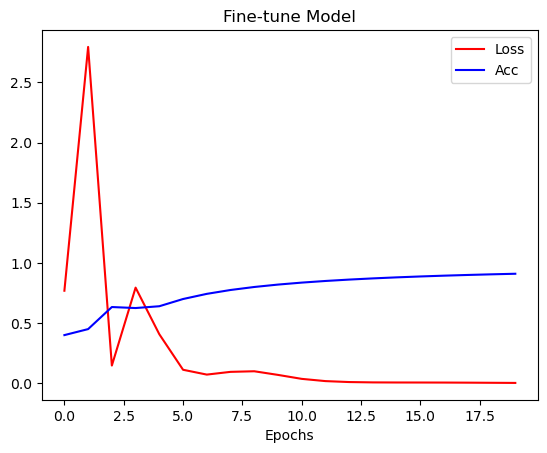

In [12]:
plt.figure()
plt.plot(f_loss,'r-')
plt.plot(f_acc,'b-')
plt.xlabel('Epochs')
plt.legend(['Loss','Acc'])
plt.title('Fine-tune Model')
plt.savefig('./plots/finetrainmodel.png')


In [14]:
print(f'Saving the weights....')
finetune_model.save_weights('./models/finetune_model_mnist',save_format='tf')
print(f'Model saved!!')

Saving the weights....
Model saved!!


In [15]:
print(f'Load the weights....')
finetune_model = mnist_model(2)
finetune_model.build_graph([28,28,1])
finetune_model.load_weights('./models/finetune_model_mnist')
print(f'Model Loaded!!!')

Load the weights....
Model Loaded!!!


In [16]:
## Test the fine-tune model on the query set of the target data

ftest_train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

def test_fine_tune(model):
    for i,(xbatch,ybatch) in enumerate(query_target_dataset):
        xbatch = tf.convert_to_tensor(xbatch)
        xbatch = xbatch[:,:,:,tf.newaxis]
        ybatch = ybatch-min(ybatch)

        ypred = model.call(xbatch)
        ftest_train_acc_metric.update_state(ybatch,ypred)
    print('Testing accuracy on query target set: ',ftest_train_acc_metric.result().numpy())

test_fine_tune(finetune_model)

Testing accuracy on query target set:  0.88383836


## Metalearning
### We first pre-train the model on first 4 classes of the source data, i.e [0,1,2,3]. 
### We then meta-train the pre-trained model on the remaining 4 classes of the source data, i.e. [4,5,6,7]. 

In [17]:
## META-LEARNING

meta_pretrain_model = mnist_model(4)
meta_pretrain_model.build_graph([28,28,1])

mptrain_acc_metric = keras.metrics.SparseCategoricalAccuracy()

def meta_pre_train(model,epochs):
    for epoch in range(epochs):
        print(f'Epoch..{epoch+1}')
        for i,(xbatch,ybatch) in enumerate(meta_pretrain_dataset):
            xbatch = tf.convert_to_tensor(xbatch)
            xbatch = tf.cast(xbatch[:,:,:,tf.newaxis],tf.float32) 
            grads,loss,logits = compute_gradients(model,xbatch,ybatch) 
            apply_gradients(foptimizer,grads,model.trainable_variables)                
            mptrain_acc_metric.update_state(ybatch,logits)
        print('Meta pre-training accuracy for each epoch: ',mptrain_acc_metric.result().numpy())
    return model

meta_pretrain_model = meta_pre_train(meta_pretrain_model,20)

Epoch..1
Meta pre-training accuracy for each epoch:  0.7455
Epoch..2
Meta pre-training accuracy for each epoch:  0.8575
Epoch..3
Meta pre-training accuracy for each epoch:  0.90183336
Epoch..4
Meta pre-training accuracy for each epoch:  0.9245
Epoch..5
Meta pre-training accuracy for each epoch:  0.9381
Epoch..6
Meta pre-training accuracy for each epoch:  0.947
Epoch..7
Meta pre-training accuracy for each epoch:  0.9542143
Epoch..8
Meta pre-training accuracy for each epoch:  0.95975
Epoch..9
Meta pre-training accuracy for each epoch:  0.9641111
Epoch..10
Meta pre-training accuracy for each epoch:  0.9677
Epoch..11
Meta pre-training accuracy for each epoch:  0.97063637
Epoch..12
Meta pre-training accuracy for each epoch:  0.9730833
Epoch..13
Meta pre-training accuracy for each epoch:  0.97515386
Epoch..14
Meta pre-training accuracy for each epoch:  0.9769286
Epoch..15
Meta pre-training accuracy for each epoch:  0.9784667
Epoch..16
Meta pre-training accuracy for each epoch:  0.9798125
Epo

In [18]:
print(f'Saving the weights....')
meta_pretrain_model.save_weights('./models/meta_pretrain_model_mnist',save_format='tf')
print(f'Model saved!!')

Saving the weights....
Model saved!!


In [19]:
print(f'Load the weights....')
meta_pretrain_model = mnist_model(4)
meta_pretrain_model.build_graph([28,28,1])
meta_pretrain_model.load_weights('./models/meta_pretrain_model_mnist')
print(f'Model Loaded!!!')

Load the weights....
Model Loaded!!!


In [20]:
## Function for dividing the episode into support and query set in source domain

def get_sup_que(classes,counter,tot_cat):
    tot_x = []
    tot_y = []
    shift = min(tot_cat)
    for c in np.sort(classes):
        lower_indx= int(counter[c-shift])
        upper_indx = int(lower_indx + batch_size)
        if upper_indx<500:
            for j in range(lower_indx,upper_indx):
                tot_x.append(classwise_x[c][j])
                tot_y.append(c)
            counter[c-shift]+=batch_size

    x_s = np.concatenate((tot_x[:k_shots],tot_x[batch_size:batch_size+k_shots]),axis=0)
    y_s = np.concatenate((tot_y[:k_shots],tot_y[batch_size:batch_size+k_shots]),axis=0)
    x_q = np.concatenate((tot_x[k_shots:batch_size],tot_x[batch_size+k_shots:]),axis=0)
    y_q = np.concatenate((tot_y[k_shots:batch_size],tot_y[batch_size+k_shots:]))

    x_s,y_s = shuffle(x_s,y_s)
    x_q,y_q = shuffle(x_q,y_q)
    return x_s,y_s,x_q,y_q,counter

  

In [21]:
k_shots = 5
batch_size = 2*k_shots

lr = 1.e-3
alpha = 1.e-3
beta = 1.e-3
base_optimizer = tf.keras.optimizers.Adam(learning_rate = alpha)
meta_optimizer = tf.keras.optimizers.Adam(learning_rate = beta)

base_acc_metric = keras.metrics.SparseCategoricalAccuracy()
meta_acc_metric = keras.metrics.SparseCategoricalAccuracy()


def meta_train(model,lr_inner,inner_updates):
    base_acc = []
    meta_acc = []
    meta_loss = []
    
    counter = np.zeros(len(source_category))
    for task in range(80):
        print(f'Task..{task+1}')
        ctgy_samples = np.random.choice(source_category,2,replace=False)
        print(ctgy_samples)
        x_s,y_s,x_q,y_q,counter = get_sup_que(ctgy_samples,counter,source_category)
        x_s = tf.convert_to_tensor(x_s)
        x_s = x_s[:,:,:,tf.newaxis]
        y_s = y_s-min(source_category)

        x_q = tf.convert_to_tensor(x_q)
        x_q = x_q[:,:,:,tf.newaxis]
        y_q = y_q-min(source_category)
        
#         for epoch in range(epochs):
        with tf.GradientTape() as test_tape:
            with tf.GradientTape() as train_tape:
                train_logits = model.call(x_s)
                train_loss = loss_fn(y_s,train_logits)
            gradients = train_tape.gradient(train_loss, model.trainable_variables)

            k = 0
            model_copy = copy_model(model,x_s,len(source_category))

            for j in range(0,len(model_copy.layers)):
                if model_copy.layers[j].trainable:
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,tf.multiply(lr_inner, gradients[k+1]))
                    k += 2

            for w in range(inner_updates):
                grads,loss,logits = compute_gradients(model_copy,x_s,y_s) 
                apply_gradients(base_optimizer,grads,model_copy.trainable_variables)                
                base_acc_metric.update_state(y_s,logits)
            print('Base accuracy for each batch: ',base_acc_metric.result().numpy())

            test_logits = model_copy.call(x_q)
            test_loss = loss_fn(y_q,test_logits)
#             print(f'META: Loss:{test_loss}..{y_q}..{np.argmax(test_logits,axis=1)}')
        meta_gradients = test_tape.gradient(test_loss, model.trainable_variables)
        meta_optimizer.apply_gradients(zip(meta_gradients, model.trainable_variables))
        meta_acc_metric.update_state(y_q,test_logits)
        print(f'Meta accuracy...{meta_acc_metric.result().numpy()}') 
        base_acc.append(base_acc_metric.result().numpy())
        meta_acc.append(meta_acc_metric.result().numpy())
        meta_loss.append(test_loss)

    return model,base_acc,meta_acc,meta_loss
        
meta_trained_model,base_acc,meta_acc,meta_loss = meta_train(meta_pretrain_model,lr,10)

Task..1
[4 6]
Base accuracy for each batch:  0.0
META: Loss:6.480395317077637..[0 2 2 2 2 0 0 0 0 2]..[2 0 0 0 0 3 1 0 0 0]
Meta accuracy...0.20000000298023224
Task..2
[6 4]
Base accuracy for each batch:  0.25
META: Loss:2.550764560699463..[2 0 2 0 0 0 2 2 2 0]..[2 2 2 2 2 2 2 2 2 2]
Meta accuracy...0.3499999940395355
Task..3
[5 7]
Base accuracy for each batch:  0.16666667
META: Loss:2.670637845993042..[1 3 1 3 1 3 1 1 3 3]..[0 1 0 1 3 3 0 1 1 0]
Meta accuracy...0.30000001192092896
Task..4
[4 5]
Base accuracy for each batch:  0.25
META: Loss:2.6803719997406006..[0 1 0 0 1 1 1 1 0 0]..[0 2 0 0 3 3 3 0 0 0]
Meta accuracy...0.3499999940395355
Task..5
[5 6]
Base accuracy for each batch:  0.28
META: Loss:1.4672590494155884..[1 2 2 1 1 2 2 1 2 1]..[3 2 2 1 0 2 2 0 2 0]
Meta accuracy...0.4000000059604645
Task..6
[4 7]
Base accuracy for each batch:  0.4
META: Loss:0.840741753578186..[0 3 3 0 3 3 0 3 0 0]..[0 0 3 1 3 3 0 0 1 0]
Meta accuracy...0.4333333373069763
Task..7
[5 7]
Base accuracy for 

Base accuracy for each batch:  0.84705883
META: Loss:0.0561346635222435..[0 0 1 1 1 0 0 1 1 0]..[0 0 1 1 1 0 0 1 1 0]
Meta accuracy...0.8313725590705872
Task..52
[4 6]
Base accuracy for each batch:  0.85
META: Loss:0.0003480914165265858..[0 2 0 0 2 2 0 2 0 2]..[0 2 0 0 2 2 0 2 0 2]
Meta accuracy...0.8346154093742371
Task..53
[4 6]
Base accuracy for each batch:  0.8528302
META: Loss:0.0010905968956649303..[0 0 2 2 2 0 2 0 2 0]..[0 0 2 2 2 0 2 0 2 0]
Meta accuracy...0.8377358317375183
Task..54
[7 4]
Base accuracy for each batch:  0.8518519
META: Loss:0.004572353791445494..[0 0 3 3 3 0 3 0 0 3]..[0 0 3 3 3 0 3 0 0 3]
Meta accuracy...0.8407407402992249
Task..55
[4 7]
Base accuracy for each batch:  0.8527273
META: Loss:0.02020012028515339..[0 3 0 3 3 3 3 0 0 0]..[0 3 0 3 3 3 3 0 0 0]
Meta accuracy...0.8436363339424133
Task..56
[7 6]
Base accuracy for each batch:  0.85535717
META: Loss:0.005912060383707285..[2 3 3 3 3 3 2 2 2 2]..[2 3 3 3 3 3 2 2 2 2]
Meta accuracy...0.8464285731315613
Task.

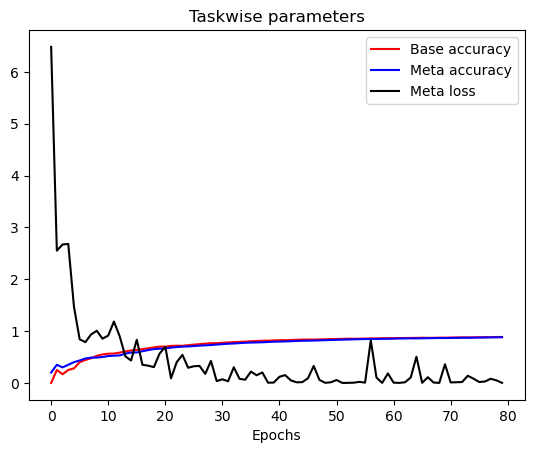

In [23]:
plt.figure()
plt.plot(base_acc,'r-')
plt.plot(meta_acc,'b-')
plt.plot(meta_loss,'k-')
plt.legend(['Base accuracy','Meta accuracy','Meta loss'])
plt.xlabel('Epochs')
plt.title('Taskwise parameters')
plt.savefig('./plots/metatrainmodel.png')


In [24]:
print(f'Saving the weights....')
meta_trained_model.save_weights('./models/meta_trained_model_mnist',save_format='tf')
print(f'Model saved!!')

Saving the weights....
Model saved!!


In [25]:
print(f'Load the weights....')
meta_trained_model = mnist_model(4)
meta_trained_model.build_graph([28,28,1])
meta_trained_model.load_weights('./models/meta_trained_model_mnist')
print(f'Model Loaded!!!')

Load the weights....
Model Loaded!!!


In [26]:
##MetaTesting on target domain data
k_shots = 5
batch_size = 2*k_shots

mbase_acc_metric = keras.metrics.SparseCategoricalAccuracy()
meta_test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

def meta_test(model,inner_updates):
    nmodel = get_updated_model(2,model)
    counter = np.zeros(len(target_category))
    
    for i,(xbatch,ybatch) in enumerate(support_target_dataset):
        xbatch = tf.convert_to_tensor(xbatch)
        xbatch = xbatch[:,:,:,tf.newaxis]
        ybatch = ybatch-min(ybatch)

        for w in range(inner_updates):
            with tf.GradientTape() as tape:
                logits = nmodel.call(xbatch)
                loss = loss_fn(ybatch,logits)
            grads = tape.gradient(loss,nmodel.trainable_variables)
            base_optimizer.apply_gradients(zip(grads,nmodel.trainable_variables))                
            mbase_acc_metric.update_state(ybatch,logits)
        print(f'Base accuracy...{mbase_acc_metric.result().numpy()}')

    for j,(xbatch,ybatch) in enumerate(query_target_dataset):
        xbatch = tf.convert_to_tensor(xbatch)
        xbatch = xbatch[:,:,:,tf.newaxis]
        ybatch = ybatch-min(ybatch)
        test_logits = nmodel.call(xbatch)
        meta_test_acc_metric.update_state(ybatch,test_logits)
    print(f'Test accuracy on query set of target data...{meta_test_acc_metric.result().numpy()}') 

meta_test(meta_trained_model,10)

Base accuracy...0.8500000238418579
Test accuracy on query set of target data...0.9404040575027466
